In [1]:
import sys
from pathlib import Path

# Exemple : ajouter le dossier parent du notebook
sys.path.append(str(Path.cwd().parent))

In [ ]:
import pandas as pd
from datetime import datetime, timezone
from opera_retrieval.utils import (
    dat_to_dat_half,
    dat_to_5mn,
    get_available_radar_dates
)
from opera_retrieval.settings import BIRDS_DATA_PATH

# =============================================================================
# Reading bird data and adding additional columns info to link it to RADAR data
# =============================================================================

birds_df = pd.read_csv(BIRDS_DATA_PATH / "data_thinned.csv")
birds_df['UTC_datetime'] = birds_df['UTC_datetime'].apply(lambda str : datetime.fromisoformat(str))
birds_df['RADAR_archive_dat'] = birds_df['UTC_datetime'].apply(lambda dat : dat_to_dat_half(dat))
birds_df['RADAR_archive_fn'] = birds_df['RADAR_archive_dat'].apply(lambda dat : f"OPERA_cirrus_REFLECTIVITY_{dat.strftime('%Y-%m-%dT%H')}0000.tar")
birds_df['RADAR_hdf5_dat'] = birds_df['UTC_datetime'].apply(lambda dat : dat_to_5mn(dat))


In [ ]:
from opera_retrieval.open_data_server import OpenDataServer

# =============================================================================
# Downloading a local RADAR database, corresponding to the bird data datetimes
# =============================================================================

# Detecting lacking files in the local DB
lacking_files = [fn for fn in birds_df.RADAR_archive_fn.unique() 
                 if fn not in get_available_radar_dates().values()]
lacking_dates = [datetime.strptime(dat_str.split("_")[-1].split(".")[0],  '%Y-%m-%dT%H%M%S').replace(tzinfo=timezone.utc)
                 for dat_str in lacking_files]

# Getting the lacking data through the custom DataServer object
mf_server = OpenDataServer()

print(f"There are {len(lacking_dates)} dates lacking")
for dat in lacking_dates[::-1] :
    _ = mf_server.get_radar_composite(dat)

In [4]:
from opera_retrieval.formatting import extract_radar_da
from opera_retrieval.diagnostics import extract_reflectivity_cone, cone_geometry

# Computing the additional radar diagnostics
date = datetime(2025,6,19,6,15).replace(tzinfo=timezone.utc)
ds = extract_radar_da(date)


📡 Lecture de CIRRUS.REF_202506190615.hdf5 (2025-06-19T06:15:00+00:00)


📡 Lecture de CIRRUS.REF_202406071530.hdf5 (2024-06-07T15:30:00+00:00)


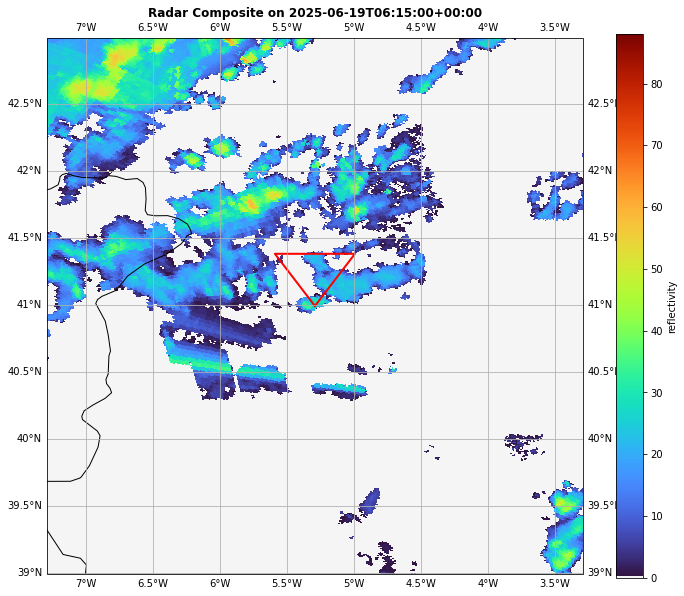

In [18]:
from opera_retrieval.plots import plot_radar_basicdataset, plot_radar_cone_da

row = birds_df.iloc[78]

lat0, lon0, heading, hdf5_dat = row.Latitude, row.Longitude, row.direction_deg, row.RADAR_hdf5_dat
O, R = 60, 50

ds = extract_radar_da(hdf5_dat.replace(tzinfo=timezone.utc))


cone_da = extract_reflectivity_cone(ds, lat0, lon0, heading, O, R)
cone_poly, axis_line = cone_geometry(lat0, lon0, heading, O, R)

bbox = (lon0-2, lon0+2, lat0-2, lat0+2) #(-12,5,40,47)
plot_radar_basicdataset(ds, dat = date, bbox=bbox, factor=1,add_poly=[cone_poly])

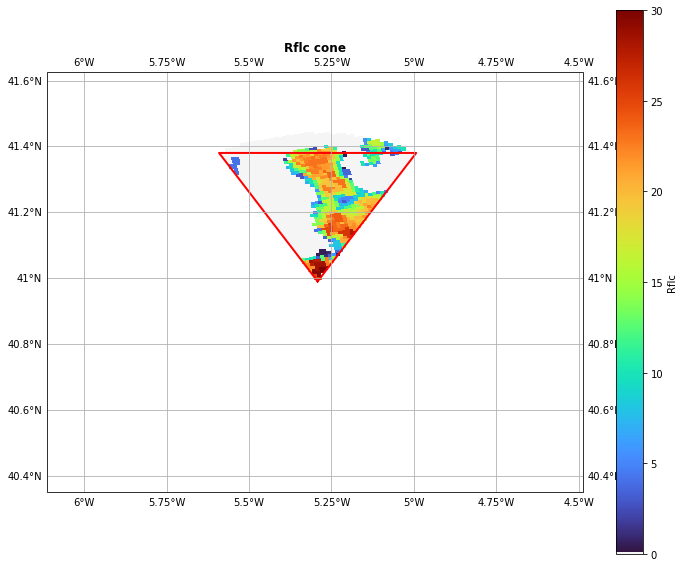

In [19]:
plot_radar_cone_da(cone_da, add_poly=[cone_poly])

In [9]:
from opera_retrieval.formatting import extract_radar_da
from opera_retrieval.diagnostics import extract_reflectivity_cone

diag_names = []

rays_lst = range(10,90,10)
overture_lst = range(45,180,45)
quant_lst = [.5,.75,.9,1]
for rayon in rays_lst :
    for overture in overture_lst :
        cone_name = f"Cone_O_{overture}_R_{rayon}"
        for quant in quant_lst :
            diag_name = f"{cone_name}_Q_{quant*100:.0f}"
            if diag_name not in birds_df.columns :
                diag_names.append(diag_name)
                
birds_df = pd.concat(
    [birds_df] + [pd.Series(None, name=n) for n in diag_names],
    axis=1
)


for idx, row in birds_df.iterrows() :
    #print(f"{idx/birds_df.shape[0]*100:.0f}%", end="\r")
    print(f"[{idx}/{birds_df.shape[0]}] : Point {row.Longitude}/{row.Latitude} at {row.UTC_datetime}")
    radar_ds = extract_radar_da(row.RADAR_hdf5_dat.replace(tzinfo=timezone.utc))
    if radar_ds :
        for rayon in rays_lst :
            for overture in overture_lst :
                # print(" \n")
                # print(f"Computing cone with radius {rayon} and angle {overture}, on position ({row.Longitude}, {row.Latitude})... ", end="")
                cone_name = f"Cone_O_{overture}_R_{rayon}"
                cone_da = extract_reflectivity_cone(radar_ds, row.Latitude, row.Longitude, row.direction_deg, overture, rayon)
                # print("OK")
                for quant in quant_lst :
                    diag_name = f"{cone_name}_Q_{quant*100:.0f}"
                    birds_df.at[idx, diag_name] = cone_da.quantile(quant, skipna=True).item()
    else :
        print(f"PROBLEM : No archive available for {row.RADAR_hdf5_dat}")
            

Point -2.137664/46.779289 at 2025-06-24 18:54:40
📡 Lecture de CIRRUS.REF_202506241855.hdf5 (2025-06-24T18:55:00+00:00)
Point -2.044693/46.425411 at 2025-06-24 19:38:59
📡 Lecture de CIRRUS.REF_202506241940.hdf5 (2025-06-24T19:40:00+00:00)
Point -2.128328/46.218044 at 2025-06-24 19:58:57
📡 Lecture de CIRRUS.REF_202506242000.hdf5 (2025-06-24T20:00:00+00:00)
Point -2.28578/45.923626 at 2025-06-24 20:28:58
📡 Lecture de CIRRUS.REF_202506242030.hdf5 (2025-06-24T20:30:00+00:00)
Point -2.538972/45.64946 at 2025-06-24 20:58:58
📡 Lecture de CIRRUS.REF_202506242100.hdf5 (2025-06-24T21:00:00+00:00)
Point -2.867223/45.45071 at 2025-06-24 21:29:07
📡 Lecture de CIRRUS.REF_202506242130.hdf5 (2025-06-24T21:30:00+00:00)
Point -3.158211/45.397842 at 2025-06-24 21:58:59
📡 Lecture de CIRRUS.REF_202506242200.hdf5 (2025-06-24T22:00:00+00:00)
Point -3.977285/43.956341 at 2025-06-25 04:45:05
📡 Lecture de CIRRUS.REF_202506250445.hdf5 (2025-06-25T04:45:00+00:00)
Point -4.256562/43.765644 at 2025-06-25 05:14:01
📡 

/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.284543/39.314819 at 2024-06-19 09:16:22
📡 Lecture de CIRRUS.REF_202406190915.hdf5 (2024-06-19T09:15:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.366886/39.188595 at 2024-06-19 09:41:33
📡 Lecture de CIRRUS.REF_202406190940.hdf5 (2024-06-19T09:40:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.354724/39.202415 at 2024-06-19 10:11:30
📡 Lecture de CIRRUS.REF_202406191010.hdf5 (2024-06-19T10:10:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.354746/39.202427 at 2024-06-19 10:41:30
📡 Lecture de CIRRUS.REF_202406191040.hdf5 (2024-06-19T10:40:00+00:00)
Point -5.354721/39.202435 at 2024-06-19 11:11:32
📡 Lecture de CIRRUS.REF_202406191110.hdf5 (2024-06-19T11:10:00+00:00)
Point -5.354685/39.202446 at 2024-06-19 11:41:31
📡 Lecture de CIRRUS.REF_202406191140.hdf5 (2024-06-19T11:40:00+00:00)
Point -5.35467/39.202507 at 2024-06-19 12:11:30
❌ Archive introuvable : /home/adrien/Documents/00_TELETRAVAIL/Travaux/opera_radar_retrieval/data_radar/OPERA_cirrus_REFLECTIVITY_2024-06-19T120000.tar
PROBLEM : No archive available for 2024-06-19 12:10:00
Point -5.354689/39.202492 at 2024-06-19 12:41:30
❌ Archive introuvable : /home/adrien/Documents/00_TELETRAVAIL/Travaux/opera_radar_retrieval/data_radar/OPERA_cirrus_REFLECTIVITY_2024-06-19T120000.tar
PROBLEM : No archive available for 2024-06-19 12:40:00
Point -5.354648/39.202526 at 2024-06-19 13:11:31
❌ Archive introuvable : /home/adrien/Documents/00_TELETRAVAIL/Travaux/opera_radar_ret

/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.596664/41.834618 at 2025-06-10 14:58:51
📡 Lecture de CIRRUS.REF_202506101500.hdf5 (2025-06-10T15:00:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.596674/41.834679 at 2025-06-10 15:28:50
📡 Lecture de CIRRUS.REF_202506101530.hdf5 (2025-06-10T15:30:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -5.596669/41.834656 at 2025-06-10 15:58:47
📡 Lecture de CIRRUS.REF_202506101600.hdf5 (2025-06-10T16:00:00+00:00)
Point -5.613312/41.829922 at 2025-06-10 16:28:49
📡 Lecture de CIRRUS.REF_202506101630.hdf5 (2025-06-10T16:30:00+00:00)
Point -5.617729/41.829868 at 2025-06-10 16:58:47
📡 Lecture de CIRRUS.REF_202506101700.hdf5 (2025-06-10T17:00:00+00:00)
Point -5.596518/41.834618 at 2025-06-10 17:28:47
📡 Lecture de CIRRUS.REF_202506101730.hdf5 (2025-06-10T17:30:00+00:00)
Point -5.597584/41.830345 at 2025-06-10 17:58:47
📡 Lecture de CIRRUS.REF_202506101800.hdf5 (2025-06-10T18:00:00+00:00)
Point -5.617848/41.82983 at 2025-06-10 18:28:48
📡 Lecture de CIRRUS.REF_202506101830.hdf5 (2025-06-10T18:30:00+00:00)
Point -5.781774/41.694893 at 2025-06-10 18:58:58
📡 Lecture de CIRRUS.REF_202506101900.hdf5 (2025-06-10T19:00:00+00:00)
Point -6.032619/41.457211 at 2025-06-10 19:33:49
📡 Lecture de CIRRUS.REF_202506101935.hdf5 (2025-06-10T19:35:00+00:00)
Point -6.171842/41.332371 at 2025-06-10 19:58:49


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -3.945247/45.416592 at 2024-07-29 01:34:10
📡 Lecture de CIRRUS.REF_202407290135.hdf5 (2024-07-29T01:35:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -4.066648/45.309464 at 2024-07-29 01:54:06
📡 Lecture de CIRRUS.REF_202407290155.hdf5 (2024-07-29T01:55:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -4.277994/45.137001 at 2024-07-29 02:24:05
📡 Lecture de CIRRUS.REF_202407290225.hdf5 (2024-07-29T02:25:00+00:00)
Point -4.556279/44.939419 at 2024-07-29 02:54:11
📡 Lecture de CIRRUS.REF_202407290255.hdf5 (2024-07-29T02:55:00+00:00)
Point -4.855917/44.733498 at 2024-07-29 03:24:01
📡 Lecture de CIRRUS.REF_202407290325.hdf5 (2024-07-29T03:25:00+00:00)
Point -5.112557/44.528996 at 2024-07-29 03:54:01
📡 Lecture de CIRRUS.REF_202407290355.hdf5 (2024-07-29T03:55:00+00:00)
Point -5.280416/44.30006 at 2024-07-29 04:24:04
📡 Lecture de CIRRUS.REF_202407290425.hdf5 (2024-07-29T04:25:00+00:00)
Point -5.504765/44.150272 at 2024-07-29 04:54:04
📡 Lecture de CIRRUS.REF_202407290455.hdf5 (2024-07-29T04:55:00+00:00)
Point -5.551445/43.958107 at 2024-07-29 06:10:19
📡 Lecture de CIRRUS.REF_202407290610.hdf5 (2024-07-29T06:10:00+00:00)
Point -5.563833/43.911663 at 2024-07-29 06:24:09
📡 Lecture de CIRRUS.REF_202407290625.hdf5 (2024-07-29T06:25:00+00:00)
Point -5.621216/43.752338 at 2024-07-29 07:09:05


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -6.377412/46.341763 at 2024-07-30 00:05:48
📡 Lecture de CIRRUS.REF_202407300005.hdf5 (2024-07-30T00:05:00+00:00)


/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -6.143386/46.487358 at 2024-07-30 00:25:48
📡 Lecture de CIRRUS.REF_202407300025.hdf5 (2024-07-30T00:25:00+00:00)
Point -5.923643/46.636761 at 2024-07-30 00:45:55
📡 Lecture de CIRRUS.REF_202407300045.hdf5 (2024-07-30T00:45:00+00:00)
Point -5.422026/46.897106 at 2024-07-30 01:35:48
📡 Lecture de CIRRUS.REF_202407300135.hdf5 (2024-07-30T01:35:00+00:00)
Point -5.306552/46.965919 at 2024-07-30 01:45:58
📡 Lecture de CIRRUS.REF_202407300145.hdf5 (2024-07-30T01:45:00+00:00)
Point -5.042196/46.980774 at 2024-07-30 02:15:46
📡 Lecture de CIRRUS.REF_202407300215.hdf5 (2024-07-30T02:15:00+00:00)
Point -4.788159/46.998352 at 2024-07-30 02:45:47
📡 Lecture de CIRRUS.REF_202407300245.hdf5 (2024-07-30T02:45:00+00:00)
Point -4.528831/47.028774 at 2024-07-30 03:15:46
📡 Lecture de CIRRUS.REF_202407300315.hdf5 (2024-07-30T03:15:00+00:00)
Point -4.249532/47.044262 at 2024-07-30 03:45:47
📡 Lecture de CIRRUS.REF_202407300345.hdf5 (2024-07-30T03:45:00+00:00)
Point -4.026131/47.063648 at 2024-07-30 04:16:21

/home/adrien/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Point -3.441921/46.491928 at 2025-06-11 06:05:15
📡 Lecture de CIRRUS.REF_202506110605.hdf5 (2025-06-11T06:05:00+00:00)
Point -3.155094/46.596611 at 2025-06-11 06:35:15
📡 Lecture de CIRRUS.REF_202506110635.hdf5 (2025-06-11T06:35:00+00:00)
Point -2.862141/46.705605 at 2025-06-11 07:05:16
📡 Lecture de CIRRUS.REF_202506110705.hdf5 (2025-06-11T07:05:00+00:00)
Point -2.212346/46.633621 at 2025-06-28 18:14:06
📡 Lecture de CIRRUS.REF_202506281815.hdf5 (2025-06-28T18:15:00+00:00)
Point -2.301466/46.29512 at 2025-06-28 18:44:02
📡 Lecture de CIRRUS.REF_202506281845.hdf5 (2025-06-28T18:45:00+00:00)
Point -2.45105/45.976376 at 2025-06-28 19:13:58
📡 Lecture de CIRRUS.REF_202506281915.hdf5 (2025-06-28T19:15:00+00:00)
Point -2.62375/45.665852 at 2025-06-28 19:43:57
📡 Lecture de CIRRUS.REF_202506281945.hdf5 (2025-06-28T19:45:00+00:00)
Point -2.862329/45.316647 at 2025-06-28 20:14:04
📡 Lecture de CIRRUS.REF_202506282015.hdf5 (2025-06-28T20:15:00+00:00)
Point -3.06671/44.970093 at 2025-06-28 20:44:05
📡 L

In [10]:
birds_df.to_csv("../data_birds/complete_data_thinned.csv")

In [ ]:
from opera_retrieval.formatting import radar_tar_to_geotiff
from opera_retrieval.settings import GEOTIFF_OUTPUT_PATH, CANTABRICS_BBOX

TAR_PATH = get_available_radar_dates().values()[0]

radar_tar_to_geotiff(
    tar_path=TAR_PATH,
    output_dir=GEOTIFF_OUTPUT_PATH,
    bbox=CANTABRICS_BBOX,
    timestep=60
)

Index(['device_id', 'UTC_datetime', 'UTC_date', 'UTC_time', 'Latitude',
       'Longitude', 'Altitude_m', 'speed_km_h', 'direction_deg', 'sp',
       ...
       'Cone_O_45_R_80_Q_90', 'Cone_O_45_R_80_Q_100', 'Cone_O_90_R_80_Q_50',
       'Cone_O_90_R_80_Q_75', 'Cone_O_90_R_80_Q_90', 'Cone_O_90_R_80_Q_100',
       'Cone_O_135_R_80_Q_50', 'Cone_O_135_R_80_Q_75', 'Cone_O_135_R_80_Q_90',
       'Cone_O_135_R_80_Q_100'],
      dtype='object', length=123)